# Test

## 1. Transformers

Testing the usage instructions from https://huggingface.co/transformers/task_summary.html

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

result = classifier("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

result = classifier("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

In [ ]:
from transformers import pipeline

ner_pipe = pipeline("ner")

sequence = """Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO,
therefore very close to the Manhattan Bridge which is visible from the window."""

In [ ]:
print(ner_pipe(sequence))

In [ ]:
from transformers import TFAutoModelForTokenClassification, AutoTokenizer
import tensorflow as tf

model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very" \
           "close to the Manhattan Bridge."

# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="tf")

outputs = model(inputs)[0]
predictions = tf.argmax(outputs, axis=2)

In [ ]:
for token, prediction in zip(tokens, predictions[0].numpy()):
    print((token, model.config.id2label[prediction]))

## 2. BERT

Testing instructions from https://huggingface.co/transformers/model_doc/bert.html

There are two groups of BERT modules. The standard one (BERT) uses PyTorch but we need the transformers version (TFBERT). 

In [ ]:
from transformers import BertTokenizer, TFBertForTokenClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertForTokenClassification.from_pretrained('bert-base-cased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
input_ids = inputs["input_ids"]
inputs["labels"] = tf.reshape(tf.constant([1] * tf.size(input_ids).numpy()), (-1, tf.size(input_ids))) # Batch size 1

outputs = model(inputs)
loss = outputs.loss
logits = outputs.logits

In [ ]:
logits

In [ ]:
outputs

In [ ]:
inputs

## 3. BERTje

Instructions: https://huggingface.co/GroNLP/bert-base-dutch-cased

Alternative models used by Bouma 2021: RobBERT (Delobelle), mBERT (Google), XLM-R (Conneau)

BERTje paper also mentions BERT-NL (textdata.nl)

In [ ]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = TFAutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # Tensorflow

In [ ]:
tokenizer.tokenize("Dit is een test.")

These instructions could be useful: 
* https://www.tensorflow.org/text/tutorials/classify_text_with_bert
* https://www.tensorflow.org/official_models/fine_tuning_bert

Even more: https://duckduckgo.com/?q=bert+tensorflow+text+classification

### 3.1 IMDB data set

Instructions: https://www.tensorflow.org/tutorials/keras/text_classification

In [ ]:
import os
import re
import shutil
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
os.listdir(dataset_dir)

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

FATAL ERROR!

### 3.2 Sentiment analysis

Instructions: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

Load IMDB data (skip)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Load social distancing data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
DATA_DIR = 'social_distancing_relevance'

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    DATA_DIR,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    DATA_DIR,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

This is the place where the BERT model is selected. There are mainly English language models available with one multi-lingual model which crashes the machine. No working Dutch models are found at the related website.   

In [ ]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'

map_name_to_handle = {
    'wiki40b-lm-nl':
        'https://tfhub.dev/google/wiki40b-lm-nl/1',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'wiki40b-lm-nl':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

This takes a lot of time (5 hours for imdb data), so skip it

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Results for social distancing data on training data:

| type | classes | 1 | 2 | 3 | 4 | 5 |
| -- | -- | -- | -- | -- | -- | -- |
| bert_en_uncased_L-12_H-768_A-12  | 3 | 0.550 | 0.565 | 0.580 | 0.580 | 0.587 |
| bert_multi_cased_L-12_H-768_A-12 | 3 | 0.536 | 0.554 | 0.571 | 0.599 | 0.616  |
| bert_multi_cased_L-12_H-768_A-12 | 2 | 0.791 | 0.797 | 0.843 | | |

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'social_distancing'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Resume processing here:

In [ ]:
dataset_name = 'social_distancing'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'iedereen moet afstand houden',  # this is the same sentence tried earlier
    'hou afstand',
    'niemand houdt afstand',
    'de afstand tot het doel is 11 meter',
    'ze moeten stoppen met maatregelen als 1,5 m'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
# original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
# print('Results from the model in memory:')
# print_my_examples(examples, original_results)

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

### 3.3 Prepare data for tensorflow

In [ ]:
import os
import pandas as pd

In [ ]:
DATA_DIR_IN = "../../puregome/data/annotation/"
TEXT_FILE = os.path.join(DATA_DIR_IN, "distance-tweets.csv")
LABEL_FILE = TEXT_FILE + ".human-labels.txt"
DATA_DIR_OUT = "social_distancing/"

In [ ]:
def extract_data(text_df, label_df):
    data_dict = {}
    target_annotator = ""
    for i, row in label_df.iterrows():
        if target_annotator == "":
            target_annotator = row["annotator"]
        if row["id_str"] in text_df.index and row["annotator"] == target_annotator:
            data_dict[row["id_str"]] = { "label": row["label"], "text": text_df.loc[row["id_str"]]["text"] }
    return data_dict

In [ ]:
def store_data(data_dict):
    for id_str in data_dict:
        out_dir = os.path.join(DATA_DIR_OUT, data_dict[id_str]["label"])
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
        out_file = open(os.path.join(out_dir, str(id_str) + ".txt"), "w")
        print(data_dict[id_str]["text"], file=out_file)
        out_file.close()

In [ ]:
text_df = pd.read_csv(TEXT_FILE, index_col="id_str")
label_df = pd.read_csv(LABEL_FILE, sep=" ", header=None, names=["annotator", "date", "id_str", "data_set_id", "label"])
data_dict = extract_data(text_df, label_df)

In [ ]:
len(data_dict)

This stores the tweets in subdirectories of `social_distancing` where the names of the subdirectories are equal to the labels and where each tweet is stored in a file named `id_str.txt`

In [ ]:
store_data(data_dict)

## 4. ROBBERT

Instructions: https://huggingface.co/pdelobelle/robbert-v2-dutch-base and https://github.com/iPieter/RobBERT

Requires PyTorch: https://pytorch.org/<br>
Installation command (select: pip & CPU): `pip3 install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html`

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")

In [ ]:
inputs = tokenizer("Mijn hond is schattig", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0) # Batch size 1
outputs = model(**inputs)
loss = outputs.loss
logits = outputs.logits

In [ ]:
inputs

In [ ]:
logits

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

In [ ]:
logits


In [ ]:
tokenizer("Dit is een test!")['input_ids']

In [ ]:
tokenizer.decode([0, 495, 405, 16, 364, 225, 1296, 328, 2])

In [ ]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained('roberta-base')

inputs = tokenizer("The capital of France is <mask>.", return_tensors="pt")
labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]

outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

In [ ]:
logits

## 5. BERT Fine-Tuning Tutorial with PyTorch

Python code source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, BertTokenizer, BertForSequenceClassification
import torch
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import numpy as np
import random
import numpy as np

In [ ]:
DATA_DIR = "social_distancing"
LABEL_VALUES = {'ANDERS': 0, 'EENS': 1, 'ONEENS': 2}

def read_text_file(file_name):
    text_file = open(file_name, "r")
    text = ""
    for line in text_file.read():
        text += line
    text_file.close()
    return text


def read_data(data_dir, label_values):
    data = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(DATA_DIR, label)
        if label not in label_values:
            label_values[label] = len(label_values)
        for id_file_name in os.listdir(label_dir):
            data.append({"text": read_text_file(os.path.join(label_dir, id_file_name)),
                         "label": label_values[label],
                         "id": re.sub(".txt$", "", id_file_name) })
    data = sorted(data, key=lambda item: item["id"])
    return [ data, label_values ]

In [ ]:
data, label_values = read_data(DATA_DIR, LABEL_VALUES)
sentences = [ item["text"] for item in data ]
file_labels = [ item["label"] for item in data ]

In [ ]:
num_labels = len(set(label_values.values()))

tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")

In [ ]:
def remove_initial_words(sentence, n):
    words = sentence.strip().split()
    return " ".join(words[int(n):])

In [ ]:
def make_input_ids(sentences, file_labels, keep_short_only=False):
    input_ids, attention_masks, expanded_labels, sentence_sources = [], [], [], []
    max_length = 64
    for i in range(0, len(sentences)):
        sentence = sentences[i]
        while len(sentence) > 0:
            encoded_dict = tokenizer.encode_plus(
                                sentence,
                                max_length = max_length,
                                truncation=True,
                                padding='max_length',
                                add_special_tokens = True,
                                return_attention_mask = True,
                                return_tensors = 'pt',
                           )
            if keep_short_only and encoded_dict['attention_mask'][0][max_length-1] != 0:
                break
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
            expanded_labels.append(file_labels[i])
            sentence_sources.append(i)
            sentence = remove_initial_words(sentence, int(max_length/2))
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(expanded_labels)
    return [input_ids, attention_masks, labels, sentence_sources]

In [ ]:
def keep_short_sentences(input_ids, sentence_sources):
    short_input_ids = []
    for i in range(0, len(sentence_sources)):
        if (i == 0 or sentence_sources[i] != sentence_sources[i-1]) and (i == len(sentence_sources)-1 or sentence_sources[i] != sentence_sources[i+1]):
            short_input_ids.append(input_ids[i])
    return torch.cat(short_input_ids, dim=0)

In [ ]:
def make_data(fold, sentences):
    validation_start = int(0.1 * fold * len(sentences))
    validation_end = int(0.1 * (fold + 1) * len(sentences))
    input_ids, attention_masks, labels, sentence_sources_validation = make_input_ids(sentences[validation_start:validation_end], 
                                                                                     file_labels[validation_start:validation_end], 
                                                                                     keep_short_only=False)
    val_dataset = TensorDataset(input_ids, attention_masks, labels)
    if fold == 0:
        training_sentences = []
        training_file_labels = []
    else:
        training_sentences = sentences[:validation_start]
        training_file_labels = file_labels[:validation_start]
    if fold < 9:
        training_sentences.extend(sentences[validation_end:])
        training_file_labels.extend(file_labels[validation_end:])
    input_ids, attention_masks, labels, _ = make_input_ids(training_sentences, training_file_labels, keep_short_only=True)
    train_dataset = TensorDataset(input_ids, attention_masks, labels)
    return [ train_dataset, val_dataset, sentence_sources_validation ]

In [ ]:
def make_experiment(fold, sentences):
    train_dataset, val_dataset, sentence_sources_validation = make_data(fold, sentences)
    print(f"fold: {fold}; train size: {len(train_dataset)}; validation size: {len(val_dataset)}")
    batch_size = 32
    train_dataloader = DataLoader(
                train_dataset,
                sampler = RandomSampler(train_dataset),
                batch_size = batch_size
            )
    validation_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset),
                batch_size = batch_size
            )
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5,
                      eps = 1e-8
                    )
    epochs = 2
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    return [ train_dataset, val_dataset, train_dataloader, validation_dataloader, batch_size, epochs, total_steps, optimizer, scheduler, sentence_sources_validation ]

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def get_prediction_labels(predictions):
    prediction_labels = []
    for i in range(len(predictions)):
        prediction_labels.extend(np.argmax(predictions[i], axis=1).flatten())
    return prediction_labels

In [ ]:
def collapse_labels(true_labels, predictions, sentence_sources, label_values):
    prediction_labels = get_prediction_labels(predictions)
    true_labels_flattened = []
    for array in true_labels:
         true_labels_flattened.extend(array)
    prediction_labels_collapsed = []
    true_labels_collapsed = []
    for i in range(0, len(sentence_sources)):
        if i == 0 or sentence_sources[i] != sentence_sources[i-1]:
            prediction_labels_collapsed.append(prediction_labels[i])
            true_labels_collapsed.append(true_labels_flattened[i])
        elif prediction_labels[i] != label_values['ANDERS']:
            prediction_labels_collapsed[-1] = prediction_labels[i]
    return [ true_labels_collapsed, prediction_labels_collapsed ]

In [ ]:
def train_model(model, train_dataloader, device, optimizer, scheduler):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}    Loss: {:.3f}.'.format(step, len(train_dataloader), elapsed, total_train_loss/step))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)
        model.zero_grad()        
        model_output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = model_output["loss"]
        logits = model_output["logits"]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    return avg_train_loss, training_time

In [ ]:
def validate_model(model, validation_dataloader, device, sentence_sources_validation, label_values):
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    logits_total, label_ids_total = [], []
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            model_output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = model_output["loss"]
        logits = model_output["logits"]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        logits_total.append(logits)
        label_ids_total.append(label_ids)
    true_labels_collapsed, prediction_labels_collapsed = collapse_labels(label_ids_total, logits_total, sentence_sources_validation, label_values)
    print(confusion_matrix(true_labels_collapsed, prediction_labels_collapsed))
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.3f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.3f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    return [ avg_val_accuracy, avg_val_loss, validation_time, true_labels_collapsed, prediction_labels_collapsed ]

In [ ]:
true_labels = []
predicted_labels = []
for fold in range(9, 10):
    model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base", num_labels = num_labels)
    train_dataset, val_dataset, train_dataloader, validation_dataloader, batch_size, epochs, total_steps, optimizer, scheduler, sentence_sources_validation = \
        make_experiment(fold, sentences)
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():
         torch.cuda.manual_seed_all(seed_val)
    training_stats = []
    total_t0 = time.time()

    device = torch.device("cpu")
    print(f"======== Fold {fold:2d} ============")
    for epoch_i in range(0, epochs):
        avg_train_loss, training_time = train_model(model, train_dataloader, device, optimizer, scheduler)
        avg_val_accuracy, avg_val_loss, validation_time, true_labels_collapsed, prediction_labels_collapsed = \
            validate_model(model, validation_dataloader, device, sentence_sources_validation, label_values)
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    true_labels.extend(true_labels_collapsed)
    predicted_labels.extend(prediction_labels_collapsed)
    print("")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
confusion_matrix(true_labels, predicted_labels)

In [ ]:
def get_accuracy(cm):
    correct = 0
    wrong = 0
    for i in range(0, len(cm)):
        for j in range(0, len(cm)):
            if i == j:
                correct += cm[i][j]
            else:
                wrong += cm[i][j]
    return correct/(correct+wrong)

In [ ]:
get_accuracy(confusion_matrix(true_labels, predicted_labels))

In [ ]:
def training_overview(training_stats):
    pd.set_option('precision', 2)
    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')
    return df_stats

In [ ]:
def training_graph(df_stats):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (6,4)
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks()
    plt.show()

In [ ]:
df_stats = training_overview(training_stats)
training_graph(df_stats)
df_stats

### 5.1 Only run when a test set is available

In [ ]:
def process_test_data(test_dataloader):
    print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))
    model.eval()
    predictions , true_labels = [], []
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    print('    DONE.')
    return [ true_labels, predictions ]

In [ ]:
def show_evaluation_results(true_labels, predictions):
    prediction_labels = get_prediction_labels(predictions)
    true_labels_flattened = []
    for array in true_labels:
         true_labels_flattened.extend(array)
    print(label_values)
    return confusion_matrix(true_labels_flattened, prediction_labels)

In [ ]:
true_labels, predictions = process_test_data(test_dataloader)

In [ ]:
true_labels_collapsed, predictions_collapsed = collapse_labels(true_labels, predictions, sentence_sources_test, label_values)

In [ ]:
cm = confusion_matrix(true_labels_collapsed, predictions_collapsed)
print(f"accuracy: {get_accuracy(cm):.3f}")
print(cm)

In [ ]:
show_evaluation_results(true_labels, predictions)

Confusion matrix for three-label task:
<pre>
{'ONEENS': 0, 'EENS': 1, 'ANDERS': 2}

array([[ 50,  41,  22],
       [ 13, 106,  16],
       [ 10,  56,  23]])
</pre>

### 5.2 To do

1. &#10003; showing validation accuracy during run
2. &#10003; testing on all data including tweets of more than mac_length-2 tokens
3. &#10003; perform validation data test like test data test
4. &#10003; 10-cv test

## 6. Evaluate from confusion matrices

In [ ]:
cms = [
       [[ 18, 128,  18], # 0
        [  5, 395,  10],
        [  1,  20,   2]],
       [[ 12,  61,   8], # 1
        [ 14, 468,  13],
        [  3,  18,   1]],
       [[ 18, 102,  10], # 2
        [  8, 412,  11],
        [  4,  30,   3]],
       [[ 20,  88,  24], # 3
        [ 19, 342,  20],
        [  8,  40,  36]],
       [[ 36, 102,  33], # 4
        [ 22, 262,  26],
        [ 13,  49,  55]],
       [[ 26,  87,  23], # 5
        [  8, 306,  17],
        [  6,  78,  47]],
       [[ 17,  85,  19], # 6
        [ 13, 252,   9],
        [ 14, 116,  72]],
       [[ 33,  85,  46], # 7
        [ 19, 209,  23],
        [ 17,  98,  68]],
       [[ 37, 102,  33], # 8
        [ 14, 216,  15],
        [ 20, 106,  55]],
       [[ 20, 111,  21], # 9
        [ 10, 198,  25],
        [ 23, 113,  77]],
      ]

In [ ]:
cm_size = len(cms[0])
tp, tn, fp, fn = cm_size*[0], cm_size*[0], cm_size*[0], cm_size*[0]
correct, wrong = 0, 0
largest_class, rest = 0, 0
for cm in cms:
    for row_i in range(0, cm_size):
        for column_i in range(0, cm_size):
            if column_i == row_i:
                correct += cm[row_i][column_i]
                for i in range(0, cm_size):
                    if i == row_i:
                        tp[i] += cm[row_i][column_i]
                    else:
                        tn[i] += cm[row_i][column_i]
            else:
                wrong += cm[row_i][column_i]
                for i in range(0, cm_size):
                    if i == row_i:
                        fn[i] += cm[row_i][column_i]
                    elif i == column_i:
                        fp[i] += cm[row_i][column_i]
                    else:
                        tn[i] += cm[row_i][column_i]
            if row_i == 1:
                largest_class += cm[row_i][column_i]
            else:
                rest += cm[row_i][column_i]
    
precision, recall, f1, accuracy = cm_size*[0], cm_size*[0], cm_size*[0], cm_size*[0]
for i in range(0, cm_size):
    precision[i] = tp[i] / (tp[i] + fp[i])
    recall[i] = tp[i] / (tp[i] + fn[i])
    f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    accuracy[i] = (tp[i] + tn[i]) / (tp[i] + tn[i] + fp[i] + fn[i])
    print(f"{i}: precision {precision[i]:0.3f}; recall: {recall[i]:0.3f}; f1: {f1[i]:0.3f}; accuracy: {accuracy[i]:0.3f}")
print(f"overall accuracy: {correct / (correct+wrong):0.3f}")
print(f"baseline accuracy: {largest_class / (largest_class+rest):0.3f}")

The overall accuracy should be compared with the score obtained by fastText for this data set: 0.656 (CLIN 31 paper, Table 2). Note that RobBERT only used short tweets (less than 63 tokens, about 68%) for training. The testing data were identical.

In [ ]:
tp[1]

In [ ]:
sum([sum([sum(row) for row in cm]) for cm in cms])

## 7. Token classification

Source: 
* https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Custom_Named_Entity_Recognition_with_BERT_only_first_wordpiece.ipynb

Possible alternatives:
* https://www.kaggle.com/akshay235/bert-implementation-on-ner-corpushttps://www.kaggle.com/akshay235/bert-implementation-on-ner-corpus
* https://www.kaggle.com/pendu777/bert-for-named-entity-recognitionhttps://www.kaggle.com/pendu777/bert-for-named-entity-recognition

In [ ]:
!pip install transformers seqeval

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

In [ ]:
data = pd.read_csv("ner_datasetreference.csv", encoding='unicode_escape')
data.head()

In [ ]:
data.count()

In [ ]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

In [ ]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

In [ ]:
# skipped to code blocks related to class removal

In [ ]:
labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}
labels_to_ids

In [ ]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.fillna(method='ffill')
data.head()

In [ ]:
# let's create a new column called "sentence" which groups the words by sentence 
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence 
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

In [ ]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

In [ ]:
len(data)

In [ ]:
data.iloc[41].sentence

In [ ]:
data.iloc[41].word_labels

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip().split()  
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                                  # is_pretokenized=True, 
                                  return_offsets_mapping=True, 
                                  padding='max_length', 
                                  truncation=True, 
                                  max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                # overwrite label
                encoded_labels[idx] = labels[i]
                i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

    def __len__(self):
        return self.len

In [ ]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

In [ ]:
training_set[0]

In [ ]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
    print('{0:10}  {1}'.format(token, label))

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

In [ ]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model, testing_loader)

In [ ]:
from seqeval.metrics import classification_report

print(classification_report(labels, predictions))

## 8. Example from manual

Source: https://huggingface.co/transformers/model_doc/bert.html#bertfortokenclassification

In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased')

inputs = tokenizer("John leads Pfizer in India", return_tensors="pt")
labels = torch.tensor([1] * inputs["input_ids"].size(1)).unsqueeze(0)  # Batch size 1

outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

In [ ]:
outputs

In [ ]:
inputs

In [ ]:
labels

In [ ]:
def tensor2list(tensor_data):
    return [int(x) for x in list(tensor_data)]

In [ ]:
for token_id in tensor2list(inputs["input_ids"][0]):
    print(tokenizer.decode([token_id]))

See: https://towardsdatascience.com/how-to-use-bert-from-the-hugging-face-transformer-library-d373a22b0209

In [ ]:
from torch.nn import functional as F

In [ ]:
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
    word = tokenizer.decode([token])
    new_sentence = text.replace(tokenizer.mask_token, word)
    print(new_sentence)

## 9. Roberta Named Entity Recogntion by Erik Novak

Source: https://www.kaggle.com/eriknovak/pytorch-roberta-named-entity-recognition

In [1]:
# visualization libraries
import matplotlib.pyplot as plt
import numpy as np
import re

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

# huggingface's transformers library
from transformers import RobertaForTokenClassification, RobertaTokenizer

# huggingface's datasets library
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
from datasets.features import Sequence, ClassLabel

# the tqdm library used to show the iteration progress
import tqdm
tqdmn = tqdm.notebook.tqdm

In [2]:
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

In [3]:
dataset = load_dataset("conll2003")

Reusing dataset conll2003 (/home/erikt/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


In [5]:
def read_data(file_name, ner_tag_ids):
    data = { "id": [], "tokens": [], "ner_tags": [] }
    tokens = []
    ner_tags = []
    infile = open(file_name, mode = "r", encoding = "latin1")
    for line in infile:
        if not re.search("^-DOCSTART-", line):
            try:
                token, pos_tag, ner_tag = line.split()
                if ner_tag not in ner_tag_ids:
                    ner_tag_ids[ner_tag] = len(ner_tag_ids)
                tokens.append(token)
                ner_tags.append(ner_tag_ids[ner_tag])
            except:
                if len(tokens) > 0:
                    data["id"].append(str(len(data["id"])))
                    data["tokens"].append(tokens)
                    data["ner_tags"].append(ner_tags)
                    ids = []
                    tokens = []
                    ner_tags = []
    if len(ids) > 0:
        data["id"].append(ids)
        data["tokens"].append(tokens)
        data["ner_tags"].append(ner_tags)
    infile.close()
    return [ data, ner_tag_ids ]

In [6]:
ner_tag_ids = {}
dutch_data_train, ner_tag_ids = read_data("ner/data/ned.train", ner_tag_ids)
dutch_data_validation, ner_tag_ids = read_data("ner/data/ned.testa", ner_tag_ids)
dutch_data_test, ner_tag_ids = read_data("ner/data/ned.testb", ner_tag_ids)

In [7]:
features_id = Value('string')
features_tokens = Sequence(Value('string'))
features_ner_tags = Sequence(ClassLabel(names=list(ner_tag_ids.keys())))
features = Features({"id": features_id, "tokens": features_tokens, "ner_tags": features_ner_tags })

In [8]:
dutch_data_converted = DatasetDict({ "train": Dataset.from_dict(dutch_data_train, features=features),
                                     "validation": Dataset.from_dict(dutch_data_validation, features=features),
                                     "test": Dataset.from_dict(dutch_data_test, features=features) })

In [9]:
num_labels = dutch_data_converted["train"].features['ner_tags'].feature.num_classes

In [10]:
def add_encodings(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }

In [11]:
dutch_data_converted = dutch_data_converted.map(add_encodings)

In [12]:
dutch_data_converted.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [13]:
labels = dutch_data_converted['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [14]:
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [19]:
n_epochs = 1
train_data = torch.utils.data.DataLoader(dutch_data_converted['validation'], batch_size=4)

In [21]:
train_loss = []
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    for i, batch in enumerate(tqdmn(train_data)):
        if i >= 100:
            break
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        current_loss += loss.item()
        if i % 8 == 0 and i > 0:
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(current_loss / 32)
            current_loss = 0
    optimizer.step()
    optimizer.zero_grad()

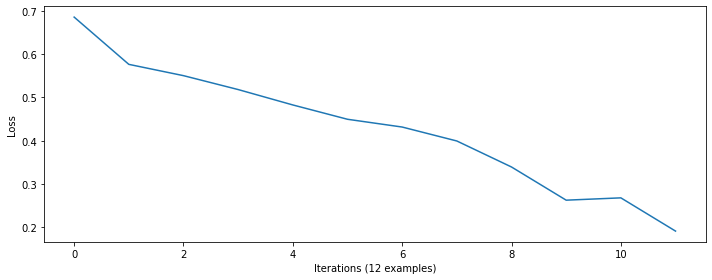

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_loss)
ax.set_ylabel('Loss')
ax.set_xlabel(f'Iterations ({len(train_loss)} examples)')
fig.tight_layout()
plt.show()

In [24]:
model = model.eval()
test_data = torch.utils.data.DataLoader(dutch_data_converted['test'], batch_size=4)

In [25]:
confusion = torch.zeros(num_labels, num_labels)
found = 0
missed = 0
wrong = 0

for i, batch in enumerate(tqdmn(test_data)):
    if i >= 100:
        break
    with torch.no_grad():
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
            
    s_lengths = batch['attention_mask'].sum(dim=1)
    for idx, length in enumerate(s_lengths):
        true_values = batch['labels'][idx][:length]
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1
            if true.item() > 0:
                if pred.item() > 0:
                    found += 1
                else: 
                    missed += 1
            elif pred.item() > 0:
                wrong += 1

KeyboardInterrupt: 

In [26]:
if found + wrong == 0:
    precision = 0.0
else:
    precision = found / (found + wrong)
recall = found / (found + missed)

print(f"precision: {precision}; recall: {recall}")

precision: 0.02702702702702703; recall: 0.007142857142857143


In [28]:
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

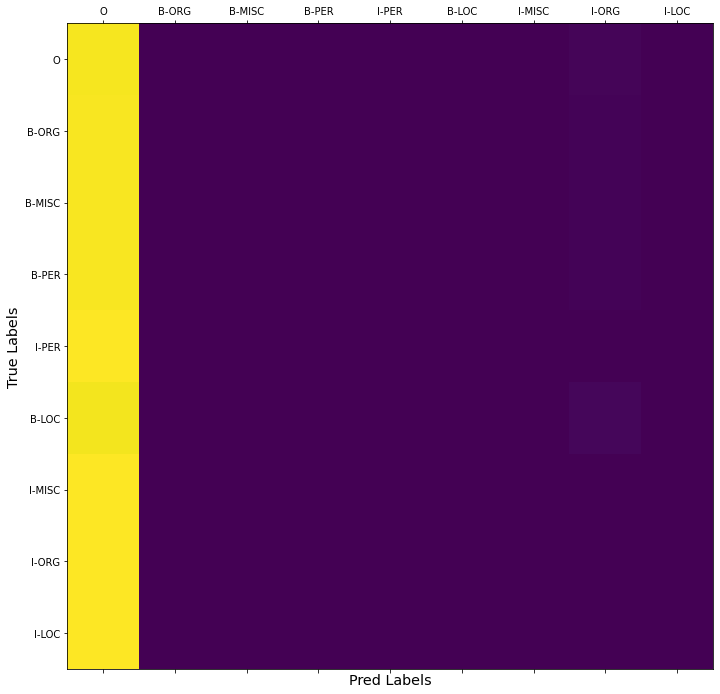

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

ax.set_xticks(ids)
ax.set_xticklabels(labels)

ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [ ]:
confusion.numpy()

In [27]:
ner_tag_ids

{'O': 0,
 'B-ORG': 1,
 'B-MISC': 2,
 'B-PER': 3,
 'I-PER': 4,
 'B-LOC': 5,
 'I-MISC': 6,
 'I-ORG': 7,
 'I-LOC': 8}